# Adapting Grad-CAM to work with more complicated models used in production

In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import datetime
import cv2

In [2]:
model_init = tf.keras.applications.InceptionV3(include_top=False)  # loading base model without last layers

Define similar model without the output layer to get the pre-softmax values

In [3]:
y = model_init.output
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(1000, activation=None, name='output_dense')(y) # activation none for Grad-CAM
model = tf.keras.models.Model(inputs=model_init.input, outputs=y)

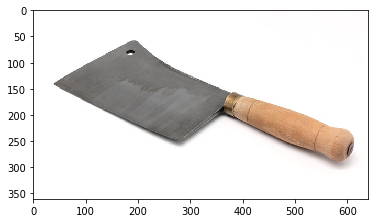

In [4]:
im = Image.open('images/cleaver.jpg')
plt.imshow(im)

In [5]:
im_tf = np.expand_dims((np.array(im.resize((299,299)))/255).astype(np.float32), axis=0)  # preprocess the input image


In [6]:
pred = model.predict(im_tf)
pred.shape  # predicts probabilities for 1000 classes by design, meat cleaver is one of those

(1, 1000)

In [7]:
np.argmax(pred)  # this is the class corresponding to the meat cleaver

299

In [8]:
np.max(pred)  # and this is the probability of the object in the photo belonging to that class according to the model

1.330709

In [9]:
model(tf.cast(im_tf, tf.float32)).shape  # use this to get tensor instead of numpy array

TensorShape([1, 1000])

In [10]:
filters = np.array([i for i in model.variables if (('conv' in i.name) and ('kernel' in i.name))])
filters.shape  # A_k is a list of all kernels within the model, so will contain all the feature maps

(94,)

In [11]:
layer_wise_outputs = np.array([i.output for i in model.layers if 'conv' in i.name])

In [12]:
len(layer_wise_outputs)

94

In [13]:
model(tf.cast(im_tf, tf.float32))

<tf.Tensor: id=14525, shape=(1, 1000), dtype=float32, numpy=
array([[-0.10789093,  0.5527064 , -0.5753481 , -0.94952047, -0.15203528,
        -0.82826424,  0.4102686 ,  0.3327429 , -0.2554714 ,  0.1616421 ,
         0.49661097,  0.07271668,  0.42373297,  0.5333069 , -0.23489377,
         0.49331656,  0.46098408, -0.5333075 ,  0.9599755 ,  0.17216936,
        -0.46823144,  0.773472  ,  0.5031834 , -0.6849158 , -0.533907  ,
         0.6624627 ,  0.21120134, -0.18639535,  0.22252843,  0.17968807,
         0.05868085,  0.31057864, -0.00292923, -0.87699467, -0.29579985,
        -0.26775622,  0.6047398 ,  0.17753224,  0.5671445 , -0.7802609 ,
        -0.09043939, -0.8935879 , -0.38700452,  0.02784053, -0.15545891,
        -0.20423448, -0.3466942 , -0.43348533, -0.48691183, -1.0324001 ,
         0.30708078,  0.1325332 , -0.3864868 , -0.45353872, -0.42508295,
         0.03315435, -0.59771556, -0.5732291 ,  0.26987898,  0.48404422,
        -0.02080192, -0.30499625, -0.02979823,  0.28348675,  0.

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization_v1[0][0]     
______________________________________________________________________________________________

In [6]:
for i in range(len(model.layers)):
    x = model.get_layer(model.layers[i].name).outbound_nodes
    if len(x) > 1:
        print(i)

17
40
63
86
100
132
164
196
228
248
256
257
279
287
288


Node objects which live inside 'outbound_nodes' or 'inbound_nodes' describe conectivity between layers with more than one input or output

In [7]:
model.get_layer(model.layers[17].name).inbound_nodes

In [8]:
model.get_layer(model.layers[17].name).inbound_nodes[0].get_config()

{'outbound_layer': 'max_pooling2d_1',
 'inbound_layers': 'activation_4',
 'node_indices': 0,
 'tensor_indices': 0}

In [9]:
model.get_layer(model.layers[17].name).outbound_nodes

In [10]:
model.get_layer(model.layers[17].name).outbound_nodes[0].get_config()

{'outbound_layer': 'conv2d_5',
 'inbound_layers': 'max_pooling2d_1',
 'node_indices': 0,
 'tensor_indices': 0}

In [11]:
model.get_layer(model.layers[0].name).outbound_nodes[0].get_config()

{'outbound_layer': 'conv2d',
 'inbound_layers': 'input_1',
 'node_indices': 0,
 'tensor_indices': 0}

In [12]:
model.get_layer(model.layers[-2].name).outbound_nodes[0].get_config()

{'outbound_layer': 'output_dense',
 'inbound_layers': 'global_average_pooling2d',
 'node_indices': 0,
 'tensor_indices': 0}

In [22]:
class tuple_dict(dict):
    """
    Custom dict object accepting tuples as 'keys' and unpacking their elements
    to get dict items corresponding to keys contained within the tuple.
    """
    def __init__(self, *args):
        dict.__init__(self, args)

    def __getitem__(self, i):
        if type(i) == tuple:
            lst = []
            for n in i:
                lst.append(dict.__getitem__(self, n))
            return lst
        elif type(i) == str:
            return dict.__getitem__(self, i)

In [23]:
def get_outputs_at_each_layer(model, input_image, layer_type):
    """
    make it robust to weird connections between layers
    """
    with tf.GradientTape() as tape:
        outputs = tuple_dict()  # custom dict object
        current_output = model.get_layer(model.layers[0].name)(input_image)
        outputs[model.layers[0].name] = current_output  # initialize first output layer
        # this is because the first layer doesn't take input from any other layer below
        restricted_outputs = []
        for i in model.layers[:]:  # iterate over all layers
            # inbound_node in config gets the input node
            # outbound_node in config points to the operation
            outbound_nodes = model.get_layer(i.name).outbound_nodes
            inbound_nodes = model.get_layer(i.name).inbound_nodes
            for n in outbound_nodes:  # iterate over outbound nodes
                                      # because we are interested in operations
                config = n.get_config()  # returns a dict
                if type(config['outbound_layer']) == list:  # convert lists to tuples
                    obl = tuple(config['outbound_layer'])
                else:
                    obl = config['outbound_layer']
                if type(config['inbound_layers']) == list:
                    ibl = tuple(config['inbound_layers'])
                else:
                    ibl = config['inbound_layers']
                out = model.get_layer(obl)(outputs[ibl])  # magic happens here
                # we call each outbound node with its inbound nodes...
                outputs[obl] = out  # ...and we append it back to the dict containing outputs
                # keys in the dict are names of layers/nodes, which allows this loop
                # to get them anytime multiple inputs are needed
                if layer_type in i.name:  # we return only those layers that we want to see (conv)
                    restricted_outputs.append(outputs[obl])
    gradients = tape.gradient(out, restricted_outputs)  # record gradients
    return restricted_outputs, gradients

In [24]:
A_k, dy_dA_k = get_outputs_at_each_layer(model, tf.cast(im_tf, tf.float32), 'conv')

In [25]:
for i in dy_dA_k:
    print(i.shape, " \n")

(1, 149, 149, 32)  

(1, 147, 147, 32)  

(1, 147, 147, 64)  

(1, 73, 73, 80)  

(1, 71, 71, 192)  

(1, 35, 35, 64)  

(1, 35, 35, 48)  

(1, 35, 35, 96)  

(1, 35, 35, 64)  

(1, 35, 35, 64)  

(1, 35, 35, 96)  

(1, 35, 35, 32)  

(1, 35, 35, 64)  

(1, 35, 35, 48)  

(1, 35, 35, 96)  

(1, 35, 35, 64)  

(1, 35, 35, 64)  

(1, 35, 35, 96)  

(1, 35, 35, 64)  

(1, 35, 35, 64)  

(1, 35, 35, 48)  

(1, 35, 35, 96)  

(1, 35, 35, 64)  

(1, 35, 35, 64)  

(1, 35, 35, 96)  

(1, 35, 35, 64)  

(1, 35, 35, 64)  

(1, 35, 35, 96)  

(1, 17, 17, 384)  

(1, 17, 17, 96)  

(1, 17, 17, 128)  

(1, 17, 17, 128)  

(1, 17, 17, 128)  

(1, 17, 17, 128)  

(1, 17, 17, 128)  

(1, 17, 17, 128)  

(1, 17, 17, 192)  

(1, 17, 17, 192)  

(1, 17, 17, 192)  

(1, 17, 17, 192)  

(1, 17, 17, 160)  

(1, 17, 17, 160)  

(1, 17, 17, 160)  

(1, 17, 17, 160)  

(1, 17, 17, 160)  

(1, 17, 17, 160)  

(1, 17, 17, 192)  

(1, 17, 17, 192)  

(1, 17, 17, 192)  

(1, 17, 17, 192)  

(1, 17, 17, 160)  

(1

In [26]:
len(dy_dA_k)  # 94 gradients, each different in shape

94

In [27]:
# gap = [tf.keras.layers.GlobalAveragePooling2D()(i) for i in dy_dA_k]

gap = np.array([tf.convert_to_tensor(np.mean(i, axis=(0, 1))) for i in dy_dA_k])
gap.shape

(94,)

In [28]:
for i in gap:
    print(i.shape, "\n")

(149, 32) 

(147, 32) 

(147, 64) 

(73, 80) 

(71, 192) 

(35, 64) 

(35, 48) 

(35, 96) 

(35, 64) 

(35, 64) 

(35, 96) 

(35, 32) 

(35, 64) 

(35, 48) 

(35, 96) 

(35, 64) 

(35, 64) 

(35, 96) 

(35, 64) 

(35, 64) 

(35, 48) 

(35, 96) 

(35, 64) 

(35, 64) 

(35, 96) 

(35, 64) 

(35, 64) 

(35, 96) 

(17, 384) 

(17, 96) 

(17, 128) 

(17, 128) 

(17, 128) 

(17, 128) 

(17, 128) 

(17, 128) 

(17, 192) 

(17, 192) 

(17, 192) 

(17, 192) 

(17, 160) 

(17, 160) 

(17, 160) 

(17, 160) 

(17, 160) 

(17, 160) 

(17, 192) 

(17, 192) 

(17, 192) 

(17, 192) 

(17, 160) 

(17, 160) 

(17, 160) 

(17, 160) 

(17, 160) 

(17, 160) 

(17, 192) 

(17, 192) 

(17, 192) 

(17, 192) 

(17, 192) 

(17, 192) 

(17, 192) 

(17, 192) 

(17, 192) 

(17, 192) 

(17, 192) 

(17, 192) 

(17, 192) 

(17, 192) 

(17, 192) 

(17, 192) 

(17, 192) 

(17, 192) 

(8, 320) 

(8, 192) 

(8, 448) 

(8, 384) 

(8, 384) 

(8, 384) 

(8, 384) 

(8, 384) 

(8, 384) 

(8, 320) 

(8, 192) 

(8, 448) 

(8, 3

In [29]:
def upsample_array(arr, final_shape):
    """
    Upsamples np.array to a desired shape. Dimesions must be congruent.
    """
    integer_div= []
    modulo = []
    out = np.copy(arr)
    assert len(final_shape) == len(arr.shape), "Output shape has to have same number of dims!"
    for i in range(len(arr.shape)):  # catch integer division and modulo for shapes to be cast
        integer_div.append(final_shape[i]//arr.shape[i])
        modulo.append(final_shape[i]%arr.shape[i])
    if len(modulo) != 0:  # increase integer shape divisor if modulo is not 0 in any dimension
        integer_div = [i+1 for i in integer_div]
    for idx, i in enumerate(integer_div):  # make array repetitions in both axes
        out = out.repeat(i, axis=idx)
    if out.shape != final_shape:  # use slices to trim to edges
        start = [None for i in range(len(final_shape))]
        end = final_shape
        zipped = tuple(zip(start, final_shape))
        slices = tuple([slice(i[0], i[1]) for i in zipped])
        out = out[slices]
    return out

In [30]:
im_tf.shape

(1, 299, 299, 3)

In [31]:
tf.math.multiply(dy_dA_k[21], A_k[21]).shape

TensorShape([1, 35, 35, 96])

In [32]:
tf.math.reduce_sum(tf.math.multiply(dy_dA_k[21], A_k[21]), axis=(3)).shape

TensorShape([1, 35, 35])

In [33]:
L_c_0 = tf.keras.layers.ReLU()(tf.math.reduce_sum(tf.math.multiply(dy_dA_k[0], A_k[0]), axis=(3)))

In [34]:
L_c_0.shape

TensorShape([1, 149, 149])

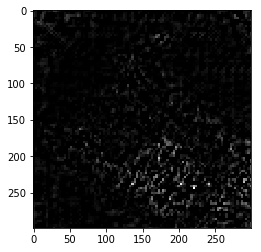

In [35]:
plt.imshow(upsample_array(L_c_0[0, :, :], (299, 299))*im_tf[0, :, :, 2], cmap='gray')

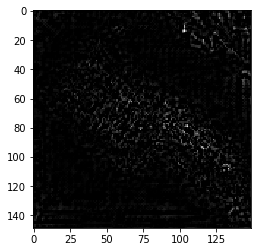

In [36]:
plt.imshow(L_c_0[0, :, :], cmap='gray')

In [37]:
L_c_0.shape

TensorShape([1, 149, 149])

In [38]:
L_c = [tf.keras.layers.ReLU()(tf.math.reduce_sum(tf.math.multiply(dy_dA_k[i], A_k[i]), axis=(3))) for i, _ in enumerate(dy_dA_k)]

In [39]:
L_c_no_single = [i for i in L_c if i.shape!=(1,1)]

In [40]:
len(L_c)

94

In [41]:
up_all = [upsample_array(i[0, :, :].numpy(), (299, 299)) for i in L_c[:]]

In [42]:
summed_maps = tf.keras.layers.ReLU()(np.sum(up_all, axis=0))
summed_maps.shape

TensorShape([299, 299])

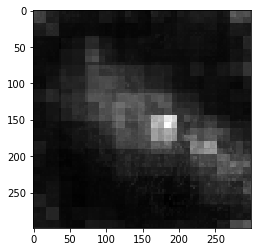

In [43]:
plt.imshow(summed_maps, cmap='gray')

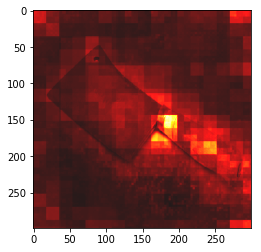

In [44]:
plt_im1 = plt.imshow(im_tf[:,:,0], cmap=plt.cm.gray, interpolation='nearest')

plt_im2 = plt.imshow(summed_maps*im_tf[:,:,:,0].reshape(299, 299), cmap=plt.cm.hot, alpha=.9, interpolation='bilinear')

plt.show()

Look into guided backprop again now.

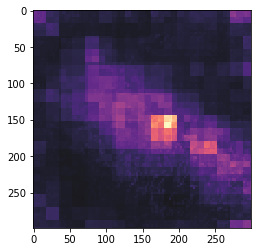

In [45]:
plt_im1 = plt.imshow(im_tf[:,:,0], cmap=plt.cm.gray, interpolation='bilinear')

plt_im2 = plt.imshow(summed_maps.numpy(), cmap='magma', alpha=.9, interpolation='nearest')

plt.show()

The upsampling that we used is very crude though and very pixelated. We can instead use PIL resize method which provides automatic interpolation of values when resizing the feature maps.

In [47]:
L_c[0].numpy().shape

(1, 149, 149)

In [48]:
up_all = [np.array(Image.fromarray(i.numpy()[0, :, :]).resize((299,299), resample=Image.BILINEAR)) for i in L_c]

In [49]:
summed_maps = tf.keras.layers.ReLU()(np.sum(up_all, axis=0))

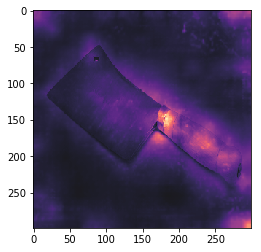

In [50]:
plt_im1 = plt.imshow(im_tf[:,:,0], cmap=plt.cm.gray, interpolation='bilinear')

plt_im2 = plt.imshow(summed_maps.numpy()*im_tf[0,:,:,0], cmap='magma', alpha=.9, interpolation='nearest')

plt.show()

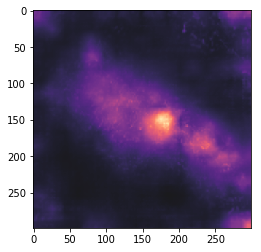

In [51]:
plt_im1 = plt.imshow(im_tf[:,:,0], cmap=plt.cm.gray, interpolation='bilinear')

plt_im2 = plt.imshow(summed_maps.numpy(), cmap='magma', alpha=.9, interpolation='nearest')

plt.show()

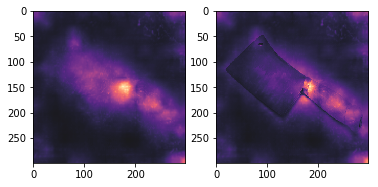

In [52]:
plt.subplot(121)
plt_im1 = plt.imshow(im_tf[:,:,0], cmap=plt.cm.gray, interpolation='bilinear')
plt_im2 = plt.imshow(summed_maps.numpy(), cmap='magma', alpha=.9, interpolation='nearest')
plt.subplot(122)
plt_im1 = plt.imshow(im_tf[:,:,0], cmap=plt.cm.gray, interpolation='bilinear')
plt_im2 = plt.imshow(summed_maps.numpy()*im_tf[0,:,:,0], cmap='magma', alpha=.9, interpolation='nearest')

plt.show()

# Python module

I provide a Python module with all those functions neatly packaged, all you need to do is import it and use `grad_cam` function to get plots with gradients. You can also provide a `return_switch` to extract values. Check docs of the function for more info.

In [53]:
import eager_gradcam

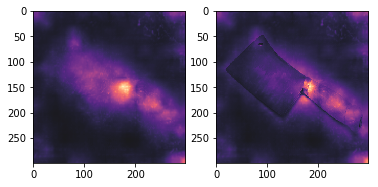

In [54]:
eager_gradcam.grad_cam('images/cleaver.jpg', model, (299,299), return_switch='no')